<a href="https://colab.research.google.com/github/Marcusrem/Deep_Learning/blob/main/ViT_Replication_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Introduction

-**About the TRANSFORMER**

A Transformer architecture is generally considered to be any neural network that uses the attention mechanism) as its primary learning layer. Similar to how a convolutional neural network (CNN) uses convolutions as its primary learning layer.

**- MAIN PRINCIPLE**: **Despite the fact we're going to be focused on replicating the ViT paper, avoid getting too bogged down on a particular paper as newer better methods will often come along, quickly, so the skill should be to remain curious whilst building the fundamental skills of turning math and words on a page into working code.**

In [ ]:
# Import torch and torchvision
import torch
import torchvision
torch.__version__, torchvision.__version__

('2.9.0+cu126', '0.24.0+cu126')

In [ ]:
# Continue to import another libraries
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work4
try:
  from torchinfo import summary
  print(f"[INFO] Couldn't find torchinfo, installinf it...")
except:
  !pip install -q torchinfo
  from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
  from going_modular.going_modular import data_setup, engine
  from helper_functions import plot_loss_curves, download_data, set_seeds
  print(f"[INFO] Couldn't find going_modular, helper_functions, downloading them from GitHub...")
except:
  # Getting scripts
  !git clone https://github.com/Marcusrem/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular  .
  !mv pytorch-deep-learning/helper_functions.py  .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine
  from helper_functions import plot_loss_curves, download_data, set_seeds

Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4403, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 4403 (delta 54), reused 34 (delta 28), pack-reused 4339 (from 2)
Receiving objects: 100% (4403/4403), 822.71 MiB | 16.35 MiB/s, done.
Resolving deltas: 100% (2683/2683), done.
Updating files: 100% (253/253), done.


In [ ]:
# Set up the device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Get the data

Throughout the `data_setup` script from going_modular

In [ ]:
# Download the pizza, steak and sushi data through the download_data setup from going_modular
image_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi_20_percent.zip",
                           destination = "pizza_steak_sushi_20")
image_path

[INFO] Did not find data/pizza_steak_sushi_20 directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20')

In [ ]:
# Set up train and test data into two different dirs
train_dir_20 = image_path/"train"
test_dir_20 = image_path/"test"

# 2. Create the DataLoaders with the `data_setup` function from `going_modular`

In [ ]:
# Setup the data transformation from the original model
IMAGE_SIZE = 224

# Set up the image transforms
simple_transforms = transforms.Compose([transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
                                       transforms.ToTensor()])
print(f"[INFO] Manually created trasnform : {simple_transforms}")

[INFO] Manually created trasnform : Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [ ]:
# Establish the batchsize
BATCH_SIZE = 64

# Create the DataLoaders
train_dataloader_20, test_dataloader_20, class_names = data_setup.create_dataloaders(train_dir = train_dir_20,
                                                                                     test_dir = test_dir_20,
                                                                                     transform = simple_transforms,
                                                                                     batch_size = BATCH_SIZE)
train_dataloader_20, test_dataloader_20, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d2f9242fa10>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# Let's visualize the data
image_batch, label_batch = next(iter(train_dataloader_20))

# Get a single ima from the batch
image, label = image_batch[0], label_batch[0]

# Get the shape of the image
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

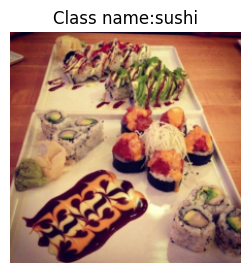

In [ ]:
# Plot the image with matplotlib
fig, ax = plt.subplots(figsize =(3,3))
ax.imshow(image.permute(1,2,0))
ax.set_title(f"Class name:{class_names[label]}")
ax.axis("off")

# 3. Replicating the ViT paper: an overview

So our model inputs are: images of pizza, steak and sushi.

And our ideal model outputs are: predicted labels of pizza, steak or sushi.

**The question is: how do we go from our inputs to the desired outputs?**

We're going to take it layer by layer, block by block, function by function *putting the pieces of the puzzle together like Lego* to get our desired overall architecture.

<img src="https://cdn.mathpix.com/snip/images/2it3VSiv1OLd99KvPONQBYalL2QPbcjlCXM0WosgiH4.original.fullsize.png" width="700"/>

**Our goal will be to replicate each of these layers, and blocks using PyTorch code**


The next main part(s) of the ViT paper we're going to look at are the four equations in section 3.1.:

<img src="https://cdn.mathpix.com/snip/images/XuzFQkEUAALzg3k2AhMY6_ReaoZZY0WMwIOR2Muoi-0.original.fullsize.png" width="700"/>

These four equations represent the math behind the four major parts of the ViT architecture.

The final piece of the ViT architecture puzzle we'll focus on (for now) is Table 1.

<img src="https://cdn.mathpix.com/snip/images/AH6uOmaIxE99xbanaCTeqT_Be85osBnVpJRd-Sw_8AQ.original.fullsize.png" width=600/>

This table showcasing the various hyperparameters of each of the ViT architectures.

You can see the numbers gradually increase from ViT-Base to ViT-Huge.

*>Hyperparmans ex.*

**Hidden size D**- This is the embedding dimension throughout the architecture, this will be the size of the vector that our image gets turned into when it gets patched and embedded. Generally, the larger the embedding dimension, the more information can be captured, the better results. However, a larger embedding comes at the cost of more computation.

**The BIBLE of replicating a paper:** ---[08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/)

---

1. Read the whole paper end-to-end once (to get an idea of the main concepts).

2. Go back through each section and see how they line up with each other and start thinking about how they might be turned into code (just like above).
3. Repeat step 2 until I've got a fairly good outline.
4. Use mathpix.com (a very handy tool) to turn any sections of the paper into markdown/LaTeX to put into notebooks.
5. Replicate the simplest version of the model possible.
6. If I get stuck, look up other examples





# 4. Equation 1: Split data into patches and creating the class, position and patch embedding

"it's all about the embedding."

As in, if you can represent your data in a good, learnable way (as embeddings are learnable representations), chances are, a learning algorithm will be able to perform well on them.

With that being said, let's start by creating the class, position and patch embeddings for the ViT architecture.

**Recall that an embedding is a learnable representation of some form and is often a vector**


**Opening paragraph of section 3.1 of the ViT paper** :


---


The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where ( $H, W$ ) is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

<img src="https://cdn.mathpix.com/snip/images/-YU7eA_M1RZ7vxE6I1eH5WPE47jDKIlG4qMKwEt1UpQ.original.fullsize.png" width=800/>

**Equation 1** : We reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$->(224,224,3) into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$->(196,768)

The opening paragraph of section 3.1 describes the different input and output shapes of the patch embedding layer.

In [ ]:
# These values were calculated as following:

H = 224 # height
W = 224 # weight
C = 3 #color channel
patch_size = 16 # folowing the paper VIT-B/16, 16 stand for the patch size

# Calculating the output shapem because the input one is the image size
N = int((H*W)/patch_size**2) # stands for number of patches
output_shape = (N, patch_size**2 * C)
print(f"[INFO] Input shape (single 2D image):{(H,W,C)}")
print(f"[INFO] Output shape (single 2D image flattened into patches) :{output_shape}")


[INFO] Input shape (single 2D image):(224, 224, 3)
[INFO] Output shape (single 2D image flattened into patches) :(196, 768)


## 4.1 Turning a single image into patches

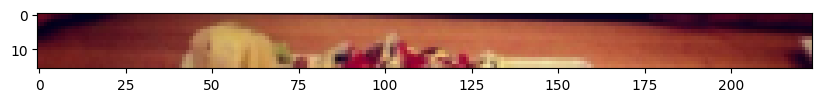

In [ ]:
# We are going to turn our image into patches and we're going to begin seeing the top row of the patched pixels
permuted_image = image.permute(1,2,0) # permute for matplotlib

#Plot the top row of the patched pixels
plt.figure(figsize=(10,10))
plt.imshow(permuted_image[:patch_size, : , :]) # exp: the H till the patch_size, the W completely and all the color channels

 [INFO] Number of patches per row : 14
 Patch size: 16 pixels * 16 pixels


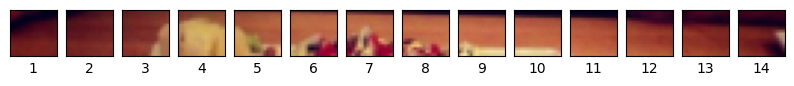

In [ ]:
#  Set up the hyper and make sure patch_size and number of patches are compatible
image_size = 224
number_of_patches_row = image_size//patch_size
assert image_size % patch_size == 0 , "Image size must be divisible by the patch size"
print(f" [INFO] Number of patches per row : {number_of_patches_row}\n Patch size: {patch_size} pixels * {patch_size} pixels")

# Create a series fo subplots
fig, ax = plt.subplots(nrows = 1,
                       ncols=number_of_patches_row,
                       figsize = (10,10),
                       sharex=True,
                       sharey=True,
                       )

# Plot across the first row following a fixed patch size
for i, patch in enumerate(range(0, image_size, patch_size)):
  ax[i].imshow(permuted_image[:patch_size,patch:patch+patch_size,:])
  ax[i].set_xlabel(i+1)
  ax[i].set_xticks([])
  ax[i].set_yticks([])


[INFO] Total number of patches : 196
[INFO] Number of patches per row: 14
[INFO] Number of patches per col: 14
[INFO] Patch size: 16 pixels * 16 pixels


Text(0.5, 0.98, 'Class name:sushi patchified')

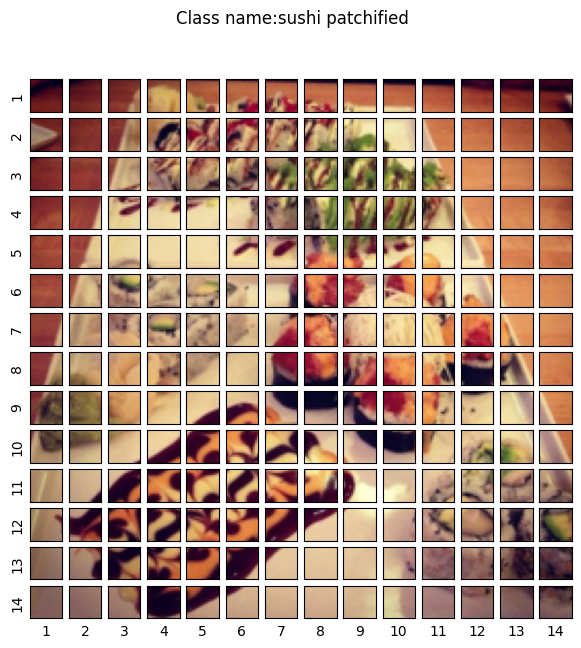

In [ ]:
# Plot the entire patched image
print(f"[INFO] Total number of patches : {N}")
print(f"[INFO] Number of patches per row: {number_of_patches_row}")
print(f"[INFO] Number of patches per col: {number_of_patches_row}")
print(f"[INFO] Patch size: {patch_size} pixels * {patch_size} pixels")

# Set the plot
fig, ax = plt.subplots(nrows=number_of_patches_row,
                       ncols=number_of_patches_row,
                       figsize=(7,7),
                       sharex=True,
                       sharey=True)

# Show the plot up iterating through the rows and then for the cols
for i, patch_height in enumerate(range(0,image_size,patch_size)):
  for j, patch_width in enumerate(range(0,image_size,patch_size)):
    ax[i,j].imshow(permuted_image[patch_height:patch_height+patch_size,patch_width:patch_width+patch_size,:])
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
    ax[i,j].set_xlabel(j+1)
    ax[i,j].set_ylabel(i+1)
    ax[i,j].label_outer()

# Set a supertitle
plt.suptitle(f"Class name:{class_names[label]} patchified", fontsize=12)

The authors of the ViT paper mention in section 3.1 t
hat the patch embedding is achievable with a convolutional neural network (CNN):


---


**Hybrid Architecture.** As an alternative to raw image patches, the input sequence can be formed from feature maps of a CNN (LeCun et al., 1989). In this hybrid model, the patch embedding projection E (Eq. 1) is applied to patches extracted from a CNN feature map. As a special case, the patches can have spatial size $1 \times 1$, which means that the input sequence is obtained by simply flattening the spatial dimensions of the **feature map** and projecting to the Transformer dimension. The classification input embedding and position embeddings are added as described above.

The **"feature map"** they're referring to are the weights/activations produced by a convolutional layer passing over a given image.

By setting the `kernel_size` and `stride` parameters of a `torch.nn.Conv2d()` layer equal to the patch_size, we can effectively get a layer that splits our image into patches and creates a learnable embedding

> `torch.nn.Conv2d()` for turning our image into patches of CNN feature maps.

> `torch.nn.Flatten()` for flattening the spatial dimensions of the feature map.

In [ ]:
# Create a Convolutional layer
from torch import nn

conv2d = nn.Conv2d(in_channels= 3,
                   out_channels =768, # This is the embedding dimension, each image will be embedded into a learnable vector of size 768
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [ ]:
permuted_image.shape

torch.Size([224, 224, 3])

In [ ]:
# Pass a single image trough the Convolutional layer
img_conv = conv2d(image.unsqueeze(0))
img_conv.shape # (Batch_Size, embbeding_dim, feature_map_height, feature_map_width)

torch.Size([1, 768, 14, 14])

**Passing our image through the convolutional layer turns it into a series of 768 feature/activation maps.**

>**OBSERVING THE CONVOLUTIONAL FEATURE MAPS FROM A SINGLE IMAGE:**

Showing random convulitonal features maps from :[190, 683, 45, 510, 652]


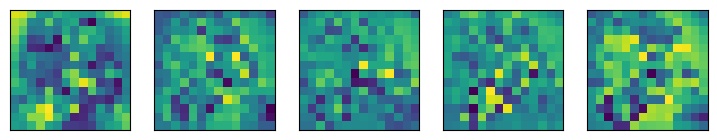

In [ ]:
# Plot 5 random feature map
# Get some random indices from the total range of learneables patterns inside the fig
import random

random_conv_idx = random.sample(range(0,767),k=5)
print(f"Showing random convulitonal features maps from :{random_conv_idx}")

# Plot the random feature maps
fig, ax = plt.subplots(nrows = 1,
                       ncols = 5,
                       figsize = (9,9))

# Plot following the random idx generated previously
for i, idx in enumerate(random_conv_idx):
  conv_feature_maps = img_conv [:,idx,:,:]
  ax[i].imshow(conv_feature_maps.squeeze().detach().numpy())
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  ax[i].set_xticklabels([])
  ax[i].set_yticklabels([])


NOTE:

**The important thing to note is that these features may change over time as the neural network learns.**

And because of these, these feature maps can be considered a **learnable embedding of our image**

In [ ]:
# Let's see a single learnable rappresentation in tensor form
single_feature_map = img_conv[:,56,:,:] # the 56th learnable rappresentation of the image
single_feature_map.requires_grad # it points out that PyTorch is tracking the gradients of this feature map and it will be updated by gradient descent during training.

True

We've turned our image into patch embeddings but they're still in 2D format.

---
As a special case, the patches can have spatial size $1 \times 1$, which means that the input sequence is
obtained by simply flattening the spatial dimensions of the **feature map** and projecting to the Transformer dimension.


---
We get them into the desired output shape of the patch embedding layer of the ViT model:`torch.nn.Flatten()`

**Desired output** (1D sequence of flattened 2D patches): (196, 768) from  the current tensor shape: torch.Size([1, 768, 14, 14])


In [ ]:
# Creating the flatten layer
flat = nn.Flatten(end_dim=3, start_dim=2) # the dims because we only want the feature maps dims
flat

Flatten(start_dim=2, end_dim=3)

In [ ]:
img_conv.shape

torch.Size([1, 768, 14, 14])

In [ ]:
# Flatten the features maps and verify the shape (pass through the flatten layer)
img_conv_flattened = flat(img_conv)
img_conv_flattened.shape

torch.Size([1, 768, 196])

In [ ]:
# Rearrange the dims to obtain the desire output shape
img_conv_flat_reshaped = img_conv_flattened.permute(0,2,1)
print(f"Patch embedding sequence shape: {img_conv_flat_reshaped.shape}")

Patch embedding sequence shape: torch.Size([1, 196, 768])


(np.float64(-0.5), np.float64(195.5), np.float64(0.5), np.float64(-0.5))

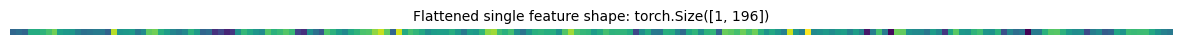

In [ ]:
# Plot a single learnable feature rappresentation
single_flattened_feature_map = img_conv_flat_reshaped[:,:,56]

fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(single_flattened_feature_map.detach().numpy())
ax.set_title(f"Flattened single feature shape: {single_flattened_feature_map.shape}", fontsize=10)
ax.axis("off")

In [ ]:
# Verifying if the flattened rappresentation of our image is a learnable embedding
single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(True, torch.Size([1, 196]))

We've turned our single 2D image into a 1D learnable embedding vector (or **"LINEAR PROJECTIONS OF FLATTENED PATCHES"** in Figure 1 of the ViT paper).

In [ ]:
# Create a class that subclass nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # Initialize the class with the proper variables
    def __init__(self,
                 in_channels:int = 3,
                 patch_size:int  = 16,
                 embedding_dim:int = 768):
      super().__init__()

      # Call the conv layer
      self.conv2d = nn.Conv2d(in_channels = in_channels,
                              out_channels= embedding_dim,
                              kernel_size = patch_size,
                              stride = patch_size,
                              padding = 0)

      # Call the Flatten layer
      self.flat = nn.Flatten(start_dim = 2, end_dim = 3)

    # Define the forward method
    def forward(self, x):
      # Create assertion to check that inputs are the correct shape
      image_resolution = x.shape[-1]
      assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

      # Perform the forward pass
      x = self.conv2d(x.unsqueeze(0))
      x = self.flat(x)
      return x.permute(0,2,1)

In [ ]:
image.shape

torch.Size([3, 224, 224])

In [ ]:
set_seeds()

# Intantiate the model's layer
patchify = PatchEmbedding()

# Verify the size of the output
print(f"[INFO] Input image shape: {image.shape}")
patch_embbeded_image = patchify(image)
print(f"[INFO] Output image shape : {patch_embbeded_image.shape}")

[INFO] Input image shape: torch.Size([3, 224, 224])
[INFO] Output image shape : torch.Size([1, 196, 768])


In [ ]:
from torchinfo import summary
# Create random input sizes
random_input_image = (3, 224, 224)
random_input_image_error = (3, 250, 250) # will error because image size is incompatible with patch_size

# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [3, 224, 224]        [1, 196, 768]        --                   True
├─Conv2d (conv2d)                        [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flat)                         [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

We've now replicated the patch embedding for **Equation 1** but not the class token/position embedding.

<img src="https://cdn.mathpix.com/snip/images/68acUfv90bEaVt4A0Injv6DtJG09pF9CwCRZKdRbjfE.original.fullsize.png" width = 1000/>

## 4.2 Creating the class token embedding

Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches ( $\mathbf{z}_0^0=\mathbf{x}_{\text {class }}$ ), whose state at the output of the Transformer encoder ( $\mathbf{z}_L^0$ ) serves as the image representation $\mathbf{y}$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

**Note**:  *BERT (Bidirectional Encoder Representations from Transformers) is one of the original machine learning research papers to use the Transformer architecture to achieve outstanding results on natural language processing (NLP) tasks and is where the idea of having a [ class ] token at the start of a sequence originated, class being a description for the "classification" class the sequence belonged to.*

So we need to **"preprend a learnable embedding to the sequence of embedded patches".**


In [ ]:
print(patch_embbeded_image)
print(patch_embbeded_image.shape)

tensor([[[-0.2120, -0.0765,  0.0371,  ...,  0.1390, -0.0993,  0.1648],
         [-0.3363, -0.0126, -0.0270,  ...,  0.1314, -0.1456,  0.1151],
         [-0.4613,  0.0693, -0.1348,  ...,  0.2704, -0.1978,  0.1803],
         ...,
         [-0.4497,  0.0891, -0.1460,  ...,  0.3240, -0.1934,  0.2596],
         [-0.4274,  0.0023, -0.1313,  ...,  0.2631, -0.1444,  0.1789],
         [-0.3285,  0.0686, -0.1283,  ...,  0.2480, -0.0873,  0.2228]]],
       grad_fn=<PermuteBackward0>)
torch.Size([1, 196, 768])


We need to create a learnable embedding in the shape of the embedding_dimension (**D**) and then add it to the number_of_patches dimension, it can be done with `torch.cat()`

-Notice the concatenation `(torch.cat())` happens on `dim=1` (the number_of_patches dimension).

-To do so, we'll get the batch size and embedding dimension shape and then we'll create a `torch.ones()` tensor in the shape [batch_size, 1, embedding_dimension].

And we'll make the tensor learnable by passing it to `nn.Parameter()` with requires_grad=True.

NOTE: Here we're only creating the class token embedding as `torch.ones()` for demonstration purposes, in reality, you'd likely create the class token embedding with `torch.randn()` (since machine learning is all about harnessing the power of controlled randomness, you generally start with a random number and improve it over time).

In [ ]:
# Get the batch size and embedding dim
batch_size = patch_embbeded_image.shape[0]
embedding_dim = patch_embbeded_image.shape[-1] # [batch_size, number_of_tokens, embedding_dimension]

# Create the learnable class token
class_token =  nn.Parameter(torch.ones(batch_size,1,embedding_dim), # [batch_size, number_of_tokens, embedding_dimension]
                            requires_grad = True) # make sure the embedding is learnable

# Show the first ex. of the class token
print(class_token[:,:,:10])

# Print the class token shape
print(f"Class token shape: {class_token.shape}") #-> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768])


In [ ]:
# let's prepend it to our sequence of image patches, patch_embedded_image
patch_embedded_class_token_image = torch.cat((class_token,patch_embbeded_image),dim=1)

# Print the shape
print(f"[INFO] Patch embedded image with class embedding:{patch_embedded_class_token_image}")
print(f"[INFO] Sequence of patch embedding with class token prepend shape : {patch_embedded_class_token_image.shape}")

[INFO] Patch embedded image with class embedding:tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.2120, -0.0765,  0.0371,  ...,  0.1390, -0.0993,  0.1648],
         [-0.3363, -0.0126, -0.0270,  ...,  0.1314, -0.1456,  0.1151],
         ...,
         [-0.4497,  0.0891, -0.1460,  ...,  0.3240, -0.1934,  0.2596],
         [-0.4274,  0.0023, -0.1313,  ...,  0.2631, -0.1444,  0.1789],
         [-0.3285,  0.0686, -0.1283,  ...,  0.2480, -0.0873,  0.2228]]],
       grad_fn=<CatBackward0>)
[INFO] Sequence of patch embedding with class token prepend shape : torch.Size([1, 197, 768])


<img src="https://cdn.mathpix.com/snip/images/OC90ZbRwXCLu2kSPVAPcWBmgk2RuxVFRDEBnqtr-99o.original.fullsize.png" width = 900/>

## 4.3 Create the position embedding

> Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

<img src= "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-the-position-embeddings.png" width = 900/>

This positional information can be important when considering what's in an image **(without positional information and a flattened sequence could be seen as having no order and thus no patch relates to any other patch).**

In [ ]:
# View a sequence of patch embedding with the prepend class embedding
patch_embedded_class_token_image, patch_embedded_class_token_image.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.2120, -0.0765,  0.0371,  ...,  0.1390, -0.0993,  0.1648],
          [-0.3363, -0.0126, -0.0270,  ...,  0.1314, -0.1456,  0.1151],
          ...,
          [-0.4497,  0.0891, -0.1460,  ...,  0.3240, -0.1934,  0.2596],
          [-0.4274,  0.0023, -0.1313,  ...,  0.2631, -0.1444,  0.1789],
          [-0.3285,  0.0686, -0.1283,  ...,  0.2480, -0.0873,  0.2228]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [ ]:
# Define the dims to consider into the learnable position token
number_of_patches = int(H*W//patch_size**2)
embedding_dim = patch_embedded_class_token_image.shape[-1]

# Create a learnable 1D position token
position_embedding = nn.Parameter(torch.ones(batch_size,
                                             number_of_patches+1,
                                             embedding_dim),
                                  requires_grad=True)

# Print the patch_emebedded learnable position token and its shape
print(f"[INFO] Position embedding: {position_embedding[:,:,:10]}")
print(f"[INFO] Position embedding shape :{position_embedding.shape} --> [batch_size,num_patches, emebdding_dim]")



[INFO] Position embedding: tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
[INFO] Position embedding shape :torch.Size([1, 197, 768]) --> [batch_size,num_patches, emebdding_dim]


Let's add them to our sequence of patch embeddings with a prepended class token

In [ ]:
patch_embedded_class_token_image.shape

torch.Size([1, 197, 768])

In [ ]:
# Add the position embeddign to the class_patch_embedding
patch_and_position_embedding = patch_embedded_class_token_image + position_embedding
print(patch_and_position_embedding)
print(f"[INFO] Patch emebddings, class token prepend and positional embedding added shape:{patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.7880, 0.9235, 1.0371,  ..., 1.1390, 0.9007, 1.1648],
         [0.6637, 0.9874, 0.9730,  ..., 1.1314, 0.8544, 1.1151],
         ...,
         [0.5503, 1.0891, 0.8540,  ..., 1.3240, 0.8066, 1.2596],
         [0.5726, 1.0023, 0.8687,  ..., 1.2631, 0.8556, 1.1789],
         [0.6715, 1.0686, 0.8717,  ..., 1.2480, 0.9127, 1.2228]]],
       grad_fn=<AddBackward0>)
[INFO] Patch emebddings, class token prepend and positional embedding added shape:torch.Size([1, 197, 768])


Notice how the values of each of the elements in the embedding tensor increases by 1 (this is because of the position embeddings being created with `torch.ones()`).

<img src = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-patch-embeddings-with-learnable-class-token-and-position-embeddings.png" width = 900/>

## 4.4. Putting it all together: from image to embedding

In [ ]:
set_seeds()

# Setting a patch size, for Vit-B|16
patch_size = 16

# Getting a single image a print its heigth and width
print(f"Image shape:{image.shape}")
H,W = image.shape[1], image.shape[2]
print(f"Image height: {H}")
print(f"Image width: {W}")

# Create a PatchEmbedding layer
patchify = PatchEmbedding()
embedded_image = patchify(image)
print(f"Patch embedded image shape : {embedded_image.shape}")

# Creating a class token embedding
batch_size = embedded_image.shape[0]
embedding_dim = embedded_image.shape[-1] # [batch_size, number_of_tokens, embedding_dimension]

class_token =  nn.Parameter(torch.randn(batch_size,1,embedding_dim), # [batch_size, number_of_tokens, embedding_dimension]
                            requires_grad = True) # make sure the embedding is learnable

# Let's prepend it to our sequence of image patches, patch_embedded_image
embedded_class_token_image = torch.cat((class_token,embedded_image),dim=1)
print(f"Patch embedded image prepended with a class token shape: {embedded_class_token_image.shape}")

# Creating a position embedding
number_of_patches = int(H*W//patch_size**2)

# Create a learnable 1D position token
position_embedding = nn.Parameter(torch.randn(batch_size,
                                              number_of_patches+1,
                                              embedding_dim),
                                  requires_grad=True)

# Adding the position embedding to the class token and patch embeddings
patch_and_position_embedding = embedded_class_token_image + position_embedding
print(f"Patch embedded image prepend by a class token and with a position embedding added shape:  {patch_and_position_embedding.shape}")
print(patch_and_position_embedding)

Image shape:torch.Size([3, 224, 224])
Image height: 224
Image width: 224
Patch embedded image shape : torch.Size([1, 196, 768])
Patch embedded image prepended with a class token shape: torch.Size([1, 197, 768])
Patch embedded image prepend by a class token and with a position embedding added shape:  torch.Size([1, 197, 768])
tensor([[[-0.4828, -2.9331, -1.0430,  ..., -0.3104,  1.8254,  0.7019],
         [-0.9070,  0.6423, -1.1039,  ..., -0.1762, -2.3214, -0.5274],
         [-1.9218, -0.3303, -1.4282,  ...,  1.9297,  0.3621,  0.1466],
         ...,
         [ 0.8358,  0.9194,  0.0036,  ..., -0.1511,  1.0730,  0.9354],
         [-0.4680, -0.5147, -0.4802,  ..., -0.2291,  0.2058,  1.5260],
         [-0.5739,  0.0639,  1.3702,  ..., -0.1595,  1.4913, -0.1053]]],
       grad_fn=<AddBackward0>)


In [ ]:
class PatchEmbedding_1(nn.Module):
  """Turn a 2D image into a 1D sequence of learnable embeddings prepend by a class token and a positional embedding added"""
  def __init__(self,
               img_size:int =224,
               in_channels:int =3,
               embedding_dim:int = 768,
               patch_size:int = 16,
               padding:float = 0
               ):
    super().__init__()

    # Calculate number of patches (height * width/patch^2)
    self.num_patches = (img_size * img_size) // patch_size**2

    # Call the conv layer
    self.conv2d = nn.Conv2d(in_channels = in_channels,
                              out_channels= embedding_dim,
                              kernel_size = patch_size,
                              stride = patch_size,
                              padding = padding)

    # Call the Flatten layer
    self.flat = nn.Flatten(start_dim = 2, end_dim = 3)

    # Creating a class token embedding
    self.class_token =  nn.Parameter(torch.randn(batch_size,1,embedding_dim), # [batch_size, number_of_tokens, embedding_dimension]
                            requires_grad = True) # make sure the embedding is learnable

    # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

    # Create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

    # Define the forward method
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

    # Perform the forward method
    #Get batch size
    batch_size = x.shape[0]

    #Create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to mantnain that dimensions as the original

    x = self.conv2d(x)
    x = self.flat(x)
    x = x.permute(0,2,1)
    x = torch.cat((class_token, x),dim=1)
    x = self.position_embedding + x

    return x

In [ ]:
set_seeds()

# Intantiate the model's layer
patchify = PatchEmbedding_1()

# Verify the size of the output
print(f"[INFO] Input image shape: {image.shape}")
patch_embbeded_image = patchify(image.unsqueeze(0))
print(f"[INFO] Output image shape : {patch_embbeded_image.shape}")

[INFO] Input image shape: torch.Size([3, 224, 224])
[INFO] Output image shape : torch.Size([1, 197, 768])


From a single image to patch and position embeddings in a single cell of code

Now we've got a way to encode our images and pass them to the Transformer Encoder in Figure 1 of the ViT paper.

From a code perspective, creating the patch embedding is probably the largest section of replicating the ViT paper.

---


<img src= "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-putting-it-all-together.png" width = 900/>

# 5. Equation 2 with PyTorch layers

Recall equation 2 states:

$$ \begin{aligned} \mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \end{aligned} $$

This indicates a Multi-Head Attention (MSA) layer wrapped in a LayerNorm (LN) layer with a residual connection (the input to the layer gets added to the output of the layer).

We'll refer to equation 2 as the "MSA block"

Many layers you find in research papers are already implemented in modern deep learning frameworks such as PyTorch.

In saying this, to replicate these layers and residual connection with PyTorch code we can use:

>- Multi-Head Self Attention (MSA) - `torch.nn.MultiheadAttention()`
>- Norm (LN or LayerNorm) - `torch.nn.LayerNorm()`
>- Residual connection - add the input to output

A. **Layer Normalization**

You can find the formal definition of `torch.nn.LayerNorm()` in the PyTorch documentation.

PyTorch's `torch.nn.LayerNorm()`  main parameter is `normalized_shape` which we can set to be equal to the dimension size we'd like to normalize over (in our case it'll be D or 768 for ViT-Base).

-*What does it do?*

Layer Normalization helps improve training time and model generalization (ability to adapt to unseen data).

B. **Multi-Head Self Attention (MSA)**

The power of the self-attention and multi-head attention (self-attention applied multiple times) were revealed in the form of the original Transformer architecture introduced in the Attention is all you need research paper.

Originally designed for text inputs, the original self-attention mechanism takes a sequence of words and then calculates which word should pay more "attention" to another word.

In other words, in the sentence "the dog jumped over the fence", perhaps the word "dog" relates strongly to "jumped" and "fence".

We're going to focus more on coding an existing PyTorch MSA implementation than creating our own.

We can implement the MSA layer in PyTorch with torch.nn.MultiheadAttention() with the parameters:

>- embed_dim - the embedding dimension from Table 1 (Hidden size $D$).
>- num_heads - how many attention heads to use (this is where the term "multihead" comes from), this value is also in Table 1 (Heads).
>- dropout - whether or not to apply dropout to the attention layer (according to Appendix B.1, dropout isn't used after the qkv-projections).
>- batch_first - does our batch dimension come first? (yes it does)

In [ ]:
class MultiheadSelfAttentionBlock(nn.Module):
  """Creates a multi-head self-attention block ("MSA block" for short).
    """
  def __init__(self,
               embedding_dim:int = 768,
               heads:int = 12,
               att_dropout:float=0
               ):
    super().__init__()
    # Create a Layer Norm
    self.layer_norm = torch.nn.LayerNorm(normalized_shape=embedding_dim)

    # Create a MSA layer
    self.msa = torch.nn.MultiheadAttention(embed_dim=embedding_dim,
                                           num_heads= heads,
                                           dropout=att_dropout,
                                           batch_first=True)
  # DO the forward method
  def forward(self, x):
    x = self.layer_norm(x)
    att_ouput, att_ouput_weight = self.msa(query = x,
                                           key = x,
                                           value = x,
                                           need_weights=False)
    return x

Let's try it out by create an instance of our MultiheadSelfAttentionBlock and passing through the patch_and_position_embedding

In [ ]:
# Let's instantiate the MSA block
msa_layer = MultiheadSelfAttentionBlock()

# Pass the patch_ebedding through it
output_msa = msa_layer(patch_and_position_embedding)
print(f" Input shape of MSA block : {patch_and_position_embedding.shape}")
print(f" Output shape of MSA block: {output_msa.shape}")

 Input shape of MSA block : torch.Size([1, 197, 768])
 Output shape of MSA block: torch.Size([1, 197, 768])


***Left:** Vision Transformer architecture from Figure 1 with Multi-Head Attention and LayerNorm layers highlighted, these layers make up equation 2 from section 3.1 of the paper. Right: Replicating equation 2 (without the skip connection on the end) using PyTorch layers.*

<img src = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-2-in-code.png" width=900/>

#6. Equation 3: Multilayer Perceptron (MLP)

$$ \begin{aligned} \mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \end{aligned} $$

Here MLP stands for "multilayer perceptron" and LN stands for "layer normalization" (as discussed above).

And the addition on the end is the skip/residual connection.

We'll refer to equation 3 as the "MLP block" of the Transformer encoder

**A. Multilayer Perceptron**

The term MLP is quite broad as it can refer to almost any combination of multiple layers (hence the "multi" in multilayer perceptron).

But it generally follows the pattern of:

`linear layer -> non-linear layer -> linear layer -> non-linear layer`

> - In the the case of the ViT paper, the MLP structure is defined in section 3.1: The MLP contains two layers with a GELU non-linearity (`torch.nn.GELU()`)


Another sneaky detail about the MLP block doesn't appear until *Appendix B.1 (Training)*:

>Table 3 summarizes our training setups for our different models. ...Dropout, when used, is applied **after every dense layer** except for the the qkv-projections and directly after adding positional- to patch embeddings.

This means that every linear layer (or dense layer) in the MLP block has a dropout layer (`torch.nn.Dropout()` in PyTorch).

> DROPOUT: During training, randomly zeroes some of the elements of the input tensor with probability p.
The zeroed elements are chosen independently for each forward call and are sampled from a Bernoulli distribution.

The value of which can be found in Table 3 of the ViT paper (for ViT-Base, dropout=0.1).

Knowing this, the structure of our MLP block will be:

`layer norm -> linear layer -> dropout -> non-linear layer -> linear layer -> dropout`

In [ ]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
  """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
  def __init__(self,
               embedding_dim:int = 768,
               mlp_size:int = 3072,
               mlp_dropout:float=0.1):
    super().__init__()

    # Create a Layer Norm
    self.layer_norm = torch.nn.LayerNorm(normalized_shape = embedding_dim)

    # Create a sequential series of MLP layers
    self.mlp = torch.nn.Sequential(nn.Linear(in_features = embedding_dim,
                                             out_features = mlp_size),
                                  nn.Dropout(p=mlp_dropout),
                                  nn.GELU(),
                                  nn.Dropout(p=mlp_dropout),
                                  nn.Linear(in_features=mlp_size,
                                            out_features=embedding_dim),
                                  nn.Dropout(p=mlp_dropout)
                                 )
  # Create the forward method and pass the inputs through the layers
  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

**Note**: Unlike Figure 1, our MLPBlock() doesn't include a skip or residual connection ("$+\mathbf{z}_{\ell}^{\prime}$" in equation 3), we'll include this when we create the entire Transformer encoder later on.

-Let's try it out by create an instance of our MLPBlock and passing through the `output_msa` variable

In [ ]:
# Instantiate the MLP block
mlp_layer = MLPBlock()

# Pass through it the msa output and print the shape
mlp_output = mlp_layer(output_msa)
print(f"Input msa layer:{output_msa.shape}")
print(f"Output msa layer: {mlp_output.shape}")

Input msa layer:torch.Size([1, 197, 768])
Output msa layer: torch.Size([1, 197, 768])




<img src = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-3-mapped-to-code.png" width =1000/>

Left: Vision Transformer architecture from Figure 1 with MLP and Norm layers highlighted, these layers make up equation 3 from section 3.1 of the paper. Right: Replicating equation 3 (without the skip connection on the end) using PyTorch layers.

# 7. Create the transformer Encoder

Time to stack together our MultiheadSelfAttentionBlock (equation 2) and MLPBlock (equation 3) and create the Transformer Encoder of the ViT architecture.

In deep learning, an "encoder" or "auto encoder" generally refers to a stack of layers that "encodes" an input (turns it into some form of numerical representation).

>Section 3.1 of the ViT Paper:
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski & Auli, 2019).

We've created MSA and MLP blocks but what about the residual connections?

**A. Residual connections**

(Also called skip connections), were first introduced in the paper "Deep Residual Learning for Image Recognition" and are achieved by adding a layer(s) input to its subsequent output.

In the case of the ViT architecture:

> `x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...`

- *What does this do?*

One of the main ideas behind residual connections is that they prevent weight values and gradient updates from getting too small and thus allow deeper networks and in turn allow deeper representations to be learned.

 **NOTE**: The iconic computer vision architecture "ResNet" is named so because of the introduction of residual connections. You can find many pretrained versions of ResNet architectures in torchvision.models.


In [ ]:
# Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    def __init__(self,
                 embedding_dim:int = 768,
                 heads:int = 12,
                 att_dropout:float = 0,
                 mlp_size:int =3072,
                 mlp_dropout:float = 0.1):
      super().__init__()

      # Instantiate msa block
      self.msa = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                             heads = heads,
                                             att_dropout=att_dropout
                                             )
      # Intantiate mlp block
      self.mlp = MLPBlock(embedding_dim = embedding_dim,
                          mlp_size = mlp_size,
                          mlp_dropout=mlp_dropout)
     # Create the forward pass and once used to process the input add the residual connections
    def forward (self, x):
      x = self.msa(x) + x
      x = self.mlp(x) + x
      return x

Let's get a `torchinfo.summary()` of passing an input of shape (1, 197, 768) -> (batch_size, num_patches, embedding_dimension) to our Transformer Encoder block.

In [ ]:
# Instantiate the Encoder
vit_encoder_block = TransformerEncoderBlock()

# Get a summary of an input pass through the encoder
summary(model = vit_encoder_block,
        input_size=(1,197,768),
        col_names =["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa)                [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (msa)                    --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

Because of their rise in popularity and effectiveness, PyTorch now has in-built Transformer layers as part of torch.nn.

```python
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layer
```

There are benefits of using the PyTorch pre-built layers, such as:

> - Less prone to errors - Generally, if a layer makes it into the PyTorch standard library, it's been tested and tried to work.
> - Potentially better performance - As of July 2022 and PyTorch 1.12, the PyTorch implemented version of torch.nn.TransformerEncoderLayer() can see a speedup of more than 2x on many common workloads.

Finally, since the ViT architecture uses several Transformer Layers stacked on top of each for the full architecture (Table 1 shows 12 Layers in the case of ViT-Base), you can do this with `torch.nn.TransformerEncoder(encoder_layer, num_layers)` where:

`encoder_layer` - The target Transformer Encoder layer created with `torch.nn.TransformerEncoderLayer()`
`num_layers` - The number of Transformer Encoder layers to stack together.

# 8. Putting it all together to create ViT

We're going to combine all of the blocks we've created to replicate the full ViT architecture.

From the patch and positional embedding to the Transformer Encoder(s) to the MLP Head.

But wait, we haven't created equation 4 yet...

$$ \begin{aligned} \mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & & \end{aligned} $$

Don't worry, we can put equation 4 into our overall ViT architecture class.

All we need is a `torch.nn.LayerNorm()` layer and a `torch.nn.Linear()` layer to convert the 0th index ($\mathbf{z}_{L}^{0}$) of the Transformer Encoder logit outputs to the target number of classes we have.

To create the full architecture, we'll also need to stack a number of our TransformerEncoderBlocks on top of each other, we can do this by passing a list of them to `torch.nn.Sequential()` (this will make a sequential range of TransformerEncoderBlocks).

In [ ]:
# Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    def __init__(self,
                 img_size: int =224,
                 color_channels: int =3,
                 patch_size: int = 16,
                 embedding_dim: int = 768,
                 heads: int = 12,
                 att_dropout:float = 0,
                 mlp_size:int = 3072,
                 mlp_dropout:float = 0.1,
                 num_transformer_layers:int = 12,
                 num_classes:int = 3,
                 embedding_dropout:float = 0.1
                 ):
      super().__init__()

      # Assert the image size is divisible for the patch size
      assert img_size % patch_size == 0 , "The image size must be divisible by the patch size"

      # Create a learnable patch embedding token
      self.patch = PatchEmbedding_1(img_size=img_size,
                                    in_channels =  color_channels,
                                    embedding_dim = embedding_dim,
                                    patch_size = patch_size,
                                    padding=0)

      # Set up an embeddingdropout layer
      self.dropout = nn.Dropout(p=embedding_dropout)

      # Create a series of Transformer Encoder blocks
      # Note: The "*" means "all"
      self.encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                             heads=heads,
                                                             att_dropout=att_dropout,
                                                             mlp_size=mlp_size,
                                                             mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)]) # potevi suare "i" invece di "_" ma tanto i non sarebbe usato. Per convenzione, in Python si scrive _ per indicare una variabile usa-e-getta.
      # Create the MLP head
      self.head = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                nn.Linear(in_features = embedding_dim,
                                          out_features = num_classes))

    # Create the forward method
    def forward(self,x):
      x = self.dropout(x)
      x = self.patch(x)
      x = self.dropout(x)
      x = self.encoder(x)
      x = self.head(x[:,0])
      return x


**Cosa significa x[:, 0]** --> Code Explanation

L’indicizzazione ha 2 parti

- `:` sul primo asse → prendi tutti i batch

- `0` sul secondo asse → prendi il primo elemento della sequenza

- Il terzo asse `(768)` non lo tocchi → quindi si mantiene.

Let's create a random tensor in the same shape as a single image, pass to an instance of ViT and see what happens.

In [ ]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[ 0.5962,  0.2958, -0.4781]], grad_fn=<AddmmBackward0>)

We handcrafted our own version of the ViT architecture and seen that a random image tensor can flow all the way through it.

How about we use `torchinfo.summary()` to get a visual overview of the input and output shapes of all the layers in our model?

In [ ]:
from torchinfo import summary

summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width
          col_names=["input_size", "output_size", "num_params", "trainable"],
          col_width=20,
          row_settings=["var_names"]
  )

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                          [32, 3, 224, 224]    [32, 3]              --                   True
├─Dropout (dropout)                                [32, 3, 224, 224]    [32, 3, 224, 224]    --                   --
├─PatchEmbedding_1 (patch)                         [32, 3, 224, 224]    [32, 197, 768]       152,832              True
│    └─Conv2d (conv2d)                             [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flat)                              [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (encoder)                             [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)               

# 9. Traning time

**A. Creating an optimizer**
Searching the ViT paper for "optimizer", section 4.1 on Training & Fine-tuning states:

> Training & Fine-tuning. We train all models, including ResNets, using Adam (Kingma & Ba, 2015 ) with $\beta_{1}=0.9, \beta_{2}=0.999$, a batch size of 4096 and apply a high weight decay of $0.1$, which we found to be useful for transfer of all models (Appendix D.1 shows that, in contrast to common practices, Adam works slightly better than SGD for ResNets in our setting).

So we can see they chose to use the "Adam" optimizer (`torch.optim.Adam()`) rather than SGD (stochastic gradient descent, `torch.optim.SGD()`).

The authors set Adam's $\beta$ (beta) values to $\beta_{1}=0.9, \beta_{2}=0.999$, these are the default values for the betas parameter in torch.optim.Adam(betas=(0.9, 0.999)).

They also state the use of weight decay (slowly reducing the values of the weights during optimization to prevent overfitting), we can set this with the weight_decay parameter in `torch.optim.Adam(weight_decay=0.3)` (according to the setting of ViT-* trained on ImageNet-1k).

We'll set the learning rate of the optimizer to 0.003 as per Table 3 (according to the setting of ViT-* trained on ImageNet-1k).

And as discussed previously, we're going to use a lower batch size than 4096 due to hardware limitations

**B. Creating a Loss Function**

Strangely, searching the ViT paper for "loss" or "loss function" or "criterion" returns no results.

However, since the target problem we're working with is multi-class classification (the same for the ViT paper), we'll use `torch.nn.CrossEntropyLoss()`

In [ ]:
from going_modular.going_modular import engine

# Set up the optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=0.001,
                             betas = (0.9,0.999),
                             weight_decay=0.3)

# Set up the loss function
loss_fn = torch.nn.CrossEntropyLoss()

## Scheduler: warm-up + cosine decay
#from torch.optim.lr_scheduler import LambdaLR
#import math

#epochs = 10
#total_steps = epochs * len(train_dataloader_20)
#warmup_steps = int(0.1 * total_steps)

#def lr_lambda(step):
    #if step < warmup_steps:
    #    return float(step) / float(max(1, warmup_steps))  # linear warmup
    #progress = float(step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    #return 0.5 * (1.0 + math.cos(math.pi * progress))  # cosine decay

#scheduler = LambdaLR(optimizer, lr_lambda)

In [ ]:
# Train for 10 epochs
vit_model_results = engine.train(model=vit,
                                 train_dataloader = train_dataloader_20,
                                 test_dataloader = test_dataloader_20,
                                 loss_fn=loss_fn,
                                 optimizer=optimizer,
                                 epochs = 10,
                                 device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2249 | train_acc: 0.4141 | test_loss: 1.6300 | test_acc: 0.4583
Epoch: 2 | train_loss: 1.4003 | train_acc: 0.3594 | test_loss: 1.4880 | test_acc: 0.2396
Epoch: 3 | train_loss: 1.1820 | train_acc: 0.2949 | test_loss: 1.1094 | test_acc: 0.4583
Epoch: 4 | train_loss: 1.1667 | train_acc: 0.3340 | test_loss: 1.0904 | test_acc: 0.3021
Epoch: 5 | train_loss: 1.1347 | train_acc: 0.3379 | test_loss: 1.0740 | test_acc: 0.4583
Epoch: 6 | train_loss: 1.1233 | train_acc: 0.2812 | test_loss: 1.1089 | test_acc: 0.3021
Epoch: 7 | train_loss: 1.1717 | train_acc: 0.2754 | test_loss: 1.1513 | test_acc: 0.2396
Epoch: 8 | train_loss: 1.2313 | train_acc: 0.2988 | test_loss: 1.0946 | test_acc: 0.4583
Epoch: 9 | train_loss: 1.1898 | train_acc: 0.4141 | test_loss: 1.1065 | test_acc: 0.3021
Epoch: 10 | train_loss: 1.1340 | train_acc: 0.3516 | test_loss: 1.1979 | test_acc: 0.2396


### PLUS: Function to upload modified version of going_modular in colab

In [ ]:
#import importlib
#from going_modular.going_modular import utils  # importa il file utils.py
#from going_modular.going_modular import engine # Agguinto GRADIENT CLIPPING nel train()

#importlib.reload(utils)  # ricarica le modifiche fatte a utils.py


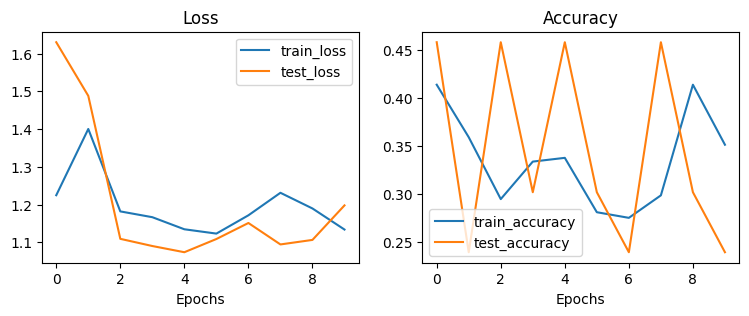

In [ ]:
from going_modular.going_modular.utils import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(vit_model_results)

### **Some tunning to the training following the paper**


---



**A. Gradient Clipping**

Purpose: Prevents exploding gradients by limiting the maximum norm of gradients.

Usually applied after loss.backward() but before optimizer.step().

**B.Learning Rate Warm-Up**

Purpose: Is a technique used to gradually increase the learning rate from a small value to a target value over a specified number of iterations or epochs. This helps in stabilizing the training process, especially in the initial stages, and can lead to better convergence and performance

Common in Transformers and large-scale training.

**C. Learning Rate Decay**

Purpose: Reduce the LR during training to help converge and prevent overshooting minima.

Can be step decay, exponential decay, cosine decay, etc.

**These results are likely because of the difference in data resources and training regime of our ViT model versus the ViT paper.**

It seems our model is severely **underfitting **

How about we see if we can fix that by bringing in a pretrained ViT model?

# 5. Using a pretrained ViT from `torchvision.models` on the same dataset
We've discussed the benefits of using pretrained models in 06. PyTorch Transfer Learning.

But since we've now trained our own ViT from scratch and achieved less than optimal results, the benefits of transfer learning (using a pretrained model) really shine.

To rent one for 30 straight days would cost $5,760 USD.

This cost (monetary and time) may be viable for some larger research teams or enterprises but for many people it's not.

So having a pretrained model available through resources like torchvision.models, the timm (Torch Image Models) library, the HuggingFace Hub or even from the authors of the papers themselves (there's a growing trend for machine learning researchers to release the code and pretrained models from their research papers, I'm a big fan of this trend, many of these resources can be found on Paperswithcode.com).

**So, we'll get the pretrained ViT-Base with patch size 16 from torchvision.models and prepare it for our FoodVision Mini use case by turning it into a feature extractor transfer learning model**.

In [ ]:
vit_model.heads

Sequential(
  (0): Linear(in_features=768, out_features=3, bias=True)
)

In [ ]:
# Get the pretrained wieghts of ViT-Base
from torchvision import models
weights_vit = models.ViT_B_16_Weights.DEFAULT

# Set up an instance of the model passing in it the pretrained weights
vit_model = models.vit_b_16(weights=weights_vit).to(device)

# Freeze up almost all the layers changing the classifier head to suit out class number
for parameters in vit_model.parameters():
  parameters.requires_grad=False

# Change the classifier head
set_seeds()
vit_model.heads = nn.Sequential(
    nn.Linear(in_features=768, out_features=3, bias=True)
)


In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=vit_model,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
         #col_names=["input_size"], # uncomment for smaller output
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"]
 )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

## 5.1 Preparing data for the pretrained ViT mode
So we don't necessarily need to do it again.

But in the name of practice, let's download some image data, only this time, let's use the 40% of the images

In [ ]:
from going_modular.going_modular.utils import download_data

image_path_1 = download_data(source = "https://github.com/Marcusrem/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_40_percent.zip",
                             destination = "pizza_steak_sushi_40")


[INFO] data/pizza_steak_sushi_40 directory exists, skipping download.


In [ ]:
# Set up a training a test dirs
train_dir_1 = image_path_1/"train"
test_dir_1  = image_path_1/"test"

train_dir_1, test_dir_1

(PosixPath('data/pizza_steak_sushi_40/train'),
 PosixPath('data/pizza_steak_sushi_40/test'))

In [ ]:
# Get the data into datalaoders

# Get the model's transformation applied to the data during its trianing
vit_model_transforms = weights_vit.transforms()

# Create the datalaoder with create_datalaoder
from going_modular.going_modular import data_setup

train_dataloader_40, test_dataloader_40, class_names = data_setup.create_dataloaders(train_dir = train_dir_1,
                                                                                     test_dir = test_dir_1,
                                                                                     transform = vit_model_transforms,
                                                                                     batch_size=32)

In [ ]:
# Let's train
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=vit_model.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=vit_model,
                                      train_dataloader=train_dataloader_40,
                                      test_dataloader=test_dataloader_40,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4362 | train_acc: 0.8621 | test_loss: 0.1385 | test_acc: 0.9542
Epoch: 2 | train_loss: 0.1554 | train_acc: 0.9515 | test_loss: 0.0933 | test_acc: 0.9781
Epoch: 3 | train_loss: 0.1216 | train_acc: 0.9623 | test_loss: 0.0876 | test_acc: 0.9750
Epoch: 4 | train_loss: 0.1027 | train_acc: 0.9720 | test_loss: 0.0786 | test_acc: 0.9750
Epoch: 5 | train_loss: 0.0912 | train_acc: 0.9784 | test_loss: 0.0761 | test_acc: 0.9750
Epoch: 6 | train_loss: 0.0766 | train_acc: 0.9828 | test_loss: 0.0739 | test_acc: 0.9750
Epoch: 7 | train_loss: 0.0841 | train_acc: 0.9784 | test_loss: 0.0747 | test_acc: 0.9781
Epoch: 8 | train_loss: 0.0564 | train_acc: 0.9925 | test_loss: 0.0710 | test_acc: 0.9812
Epoch: 9 | train_loss: 0.0482 | train_acc: 0.9925 | test_loss: 0.0692 | test_acc: 0.9844
Epoch: 10 | train_loss: 0.0431 | train_acc: 0.9925 | test_loss: 0.0690 | test_acc: 0.9844


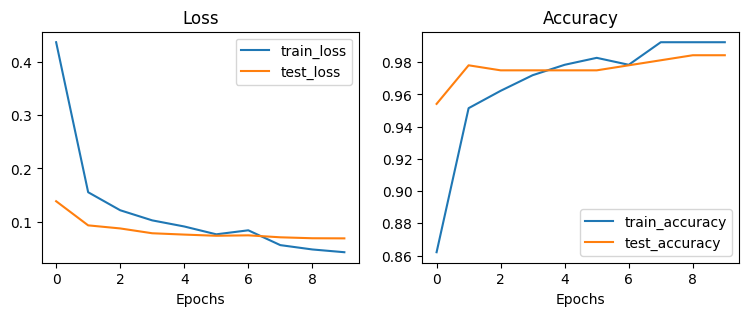

In [ ]:
# Plot the loss curves
from going_modular.going_modular.utils import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [ ]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=vit_model,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


Since we want our Food Vision Mini application to run fast, generally a smaller model with good performance will be better than a larger model with great performance.

The EffNetB2 model is ~11x smaller than the ViT model with similar results for test loss and accuracy.

However, the ViT model's results may improve more when trained with the same data (20% pizza, steak and sushi data), in fact there it is with 40% of the data 98,5% of accuracy

# 6. Making pred on a custom image




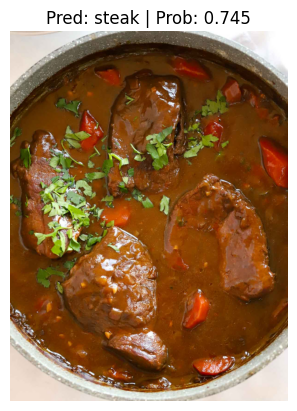

In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path_1 / "beef.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://github.com/Marcusrem/pytorch-deep-learning/raw/main/braised-steak-recipe-2.jpg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=vit_model,
                    image_path=custom_image_path,
                    class_names=class_names)